<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/geolocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geolocation prediction of Greek proverbs

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens
* Using language modelling and text classification to geolocate proverbs whose information is not known.
---


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
import ast

In [2]:
balanced_corpus = pd.read_csv("data/balanced_corpus.csv")

In [3]:
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

## Authorship analysis


In [4]:
%%capture
!git clone https://github.com/ipavlopoulos/lm
from lm.markov.models import LM

* Training one language model per area, by sampling proverbs of that area

In [5]:
# building the local language models
models = {}
for area in train.area.unique():
    texts = train[train.area==area].text.values
    models[area] = LM(gram="CHAR").train(" \n ".join(texts))

In [6]:
def ling_dist(proverb, models=models):
    '''
    Compute the bits per character (BPC) for a given proverb using many local language models

    Args:
        proverb (str): a text
        models (dict): a dictionary of language models, 
                       one per location
        
    Returns:
        string: the location whose model predicts best the text 
        pd.DataFrame: BPC per location    
    '''
    entropy = {loc:[models[loc].cross_entropy(proverb.lower())] for loc in models.keys()}
    likelier = min(entropy, key=entropy.get) 
    return likelier, pd.DataFrame(entropy)

In [7]:
# use case
loc, dists = ling_dist('κακό χωριό τα λίγα σπίτια')
dists.sort_values(by=0, ascending=True, axis=1)

,Ιωάννινα,Μικρά Ασία,Θεσπρωτία,Λακωνία,Κρήτη,Αρκαδία,Ανατολική Θράκη,Ρόδος,Ήπειρος,Κεφαλληνία,...,Επτάνησος,Αμοργός,Κάρπαθος,Θράκη,Αχαΐα,Σκύρος,Νάξος,Λέσβος,Κύπρος,Πόντος
0,3.074369,3.354174,3.361031,3.683447,3.983306,4.034237,4.043641,4.074565,4.113714,4.185229,...,4.476811,4.528474,4.786137,4.834138,4.852202,4.880689,5.069965,5.465094,5.651278,5.708093


In [8]:
def logprob(txt, mdl):
    '''Visualising the (log) probability per character for a given model
    
    Args:
        txt (string): the character sequence
        mdl (lm.markov.models.LM): the language model to be used to compute 
                                   the character probabilities
        
    Returns:
        list: the log probs of the characters in the text 
    '''
    probs = mdl.compute_gram_probs(txt)
    logprobs = map(np.log2, probs)
    return list(logprobs)


def heatmap(txt, models):
    ''' Creating a heatmap of the logprobs per local language model for a given text

    Args:
        txt (string): the text in question
        models (dict): the language models (lm.markov.models.LM) to use to score the text
        
    Returns:
        pd.DataFrame: the dataframe with the models' scores
        ax: the heatmap
    '''
    plt.rcParams["figure.figsize"] = (len(txt)/3,6); plt.rcParams["axes.labelsize"] = 23;
    probs = {loc: logprob(txt, models[loc]) for loc in models.keys()}
    df = pd.DataFrame(probs, index=[str(c) for c in txt])
    return df, sns.heatmap(df.transpose(), cmap="rocket_r")

Ο ήλιος γεννιέται για ούλλον τον κόσμον, τζαί για ούλλον τον κόσμον λάμπει (Κύπρος) -- predicted as: Κύπρος


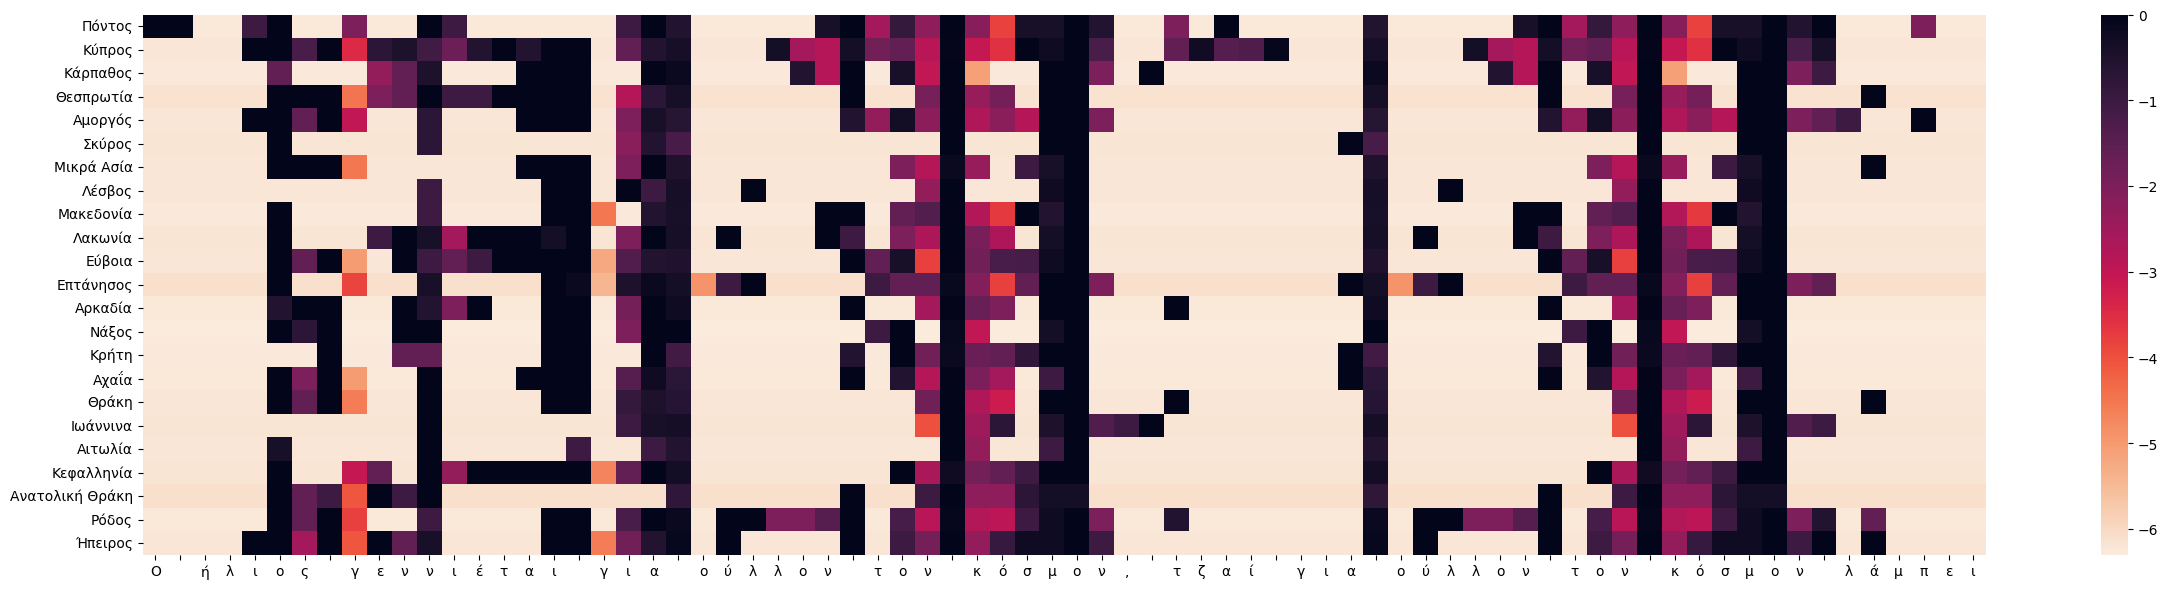

In [9]:
t = test[test.area=="Κύπρος"].sample().iloc[0]
df, ax = heatmap(t.text, models)
print(f'{t.text} ({t.area})', end=' -- ')
print(f'predicted as: {df.columns[df.mean(0).argmax()]}')
ax.figure.tight_layout(); ax.figure.savefig("heatmap.pdf", format="PDF", dpi=300)

* Evaluating on unseen proverbs

In [10]:
predictions = test.text.apply(lambda x: ling_dist(x, models=models)[0])
print(classification_report(test.area.values, predictions, zero_division=0))

                 precision    recall  f1-score   support

        Ήπειρος       0.11      0.13      0.12        23
        Αιτωλία       0.40      0.33      0.36        24
        Αμοργός       0.19      0.14      0.16        22
Ανατολική Θράκη       0.12      0.17      0.14        24
        Αρκαδία       0.08      0.06      0.07        31
          Αχαΐα       0.14      0.12      0.13        32
      Επτάνησος       0.25      0.35      0.29        23
         Εύβοια       0.07      0.15      0.10        20
      Θεσπρωτία       0.08      0.09      0.09        22
          Θράκη       0.15      0.12      0.13        25
       Ιωάννινα       0.17      0.14      0.15        29
       Κάρπαθος       0.37      0.25      0.30        28
     Κεφαλληνία       0.11      0.15      0.13        27
          Κρήτη       0.23      0.23      0.23        30
         Κύπρος       0.73      0.79      0.76        24
         Λέσβος       0.45      0.38      0.41        24
        Λακωνία       0.04    

* The confusion matrix can inform us about the confusion in the predictions

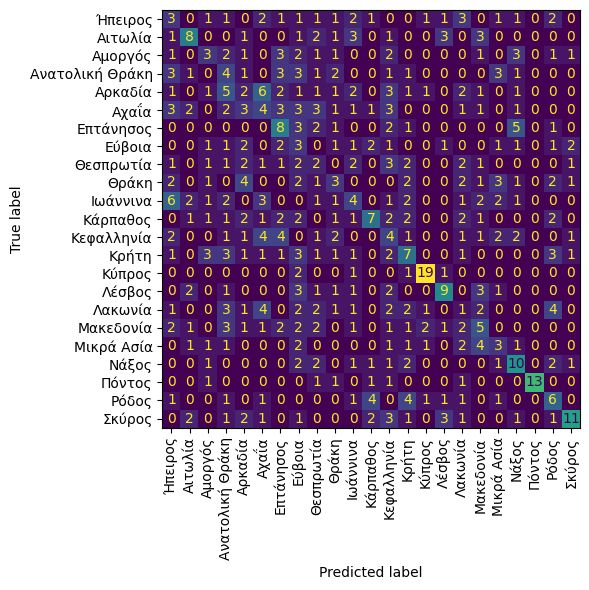

In [11]:
plt.rcParams["figure.figsize"] = (6,6); plt.rcParams["axes.labelsize"] = 12;
cm = ConfusionMatrixDisplay.from_predictions(test.area.values, predictions, xticks_rotation='vertical', colorbar=False);
cm.figure_.tight_layout(); cm.figure_.savefig('authorship_confusion.pdf', format="PDF", dpi=300)

* Benchmarking standard text classifiers, on top of chanracter n-grams

In [12]:
vect = TfidfVectorizer(ngram_range=(2,5), # token sequences
                       analyzer="char", # tokens are characters
                       max_df=0.5, # ignore tokens present in more than 50% of the texts
                       min_df=2, # ignore tokens not present in at least two documents 
                       lowercase=True)
vect.fit(train.text.values)
rep_t = vect.transform(['παροιμία'])
for i, feat in enumerate(rep_t.toarray()[0]):
    if feat>0:
        print(f'n-gram: "{vect.get_feature_names_out()[i]}" \t(tfidf: {feat:.2f})')

n-gram: "ία" 	(tfidf: 0.21)
n-gram: "αρ" 	(tfidf: 0.12)
n-gram: "αρο" 	(tfidf: 0.21)
n-gram: "αροι" 	(tfidf: 0.37)
n-gram: "ιμ" 	(tfidf: 0.19)
n-gram: "ιμί" 	(tfidf: 0.33)
n-gram: "ιμία" 	(tfidf: 0.38)
n-gram: "μί" 	(tfidf: 0.21)
n-gram: "μία" 	(tfidf: 0.30)
n-gram: "οι" 	(tfidf: 0.13)
n-gram: "οιμ" 	(tfidf: 0.28)
n-gram: "πα" 	(tfidf: 0.11)
n-gram: "παρ" 	(tfidf: 0.18)
n-gram: "παρο" 	(tfidf: 0.36)
n-gram: "ρο" 	(tfidf: 0.12)
n-gram: "ροι" 	(tfidf: 0.26)


In [13]:
# benchmarking text classification algorithms
def benchmark_clf(train, dev):
    for algo_name, algorithm in (('SVM', LinearSVC), 
                                 ('Forest', RandomForestClassifier), 
                                 ('LR', LogisticRegression)):
        locator = Pipeline([('vect', vect), ('clf', algorithm())]) 
        locator.fit(train.text.values, train.area.values) 
        txt_preds = locator.predict(dev.text.values) 
        print(f'{algo_name}: {accuracy_score(dev.area.values, txt_preds):.3f}') # <- accuracy is fine for balanced data

benchmark_clf(train, dev)

SVM: 0.287
Forest: 0.243
LR: 0.278


In [14]:
# inference on test data:
predictor_clf = Pipeline([('vect', vect), ('clf', LinearSVC())]) 
predictor_clf.fit(train.text.values, train.area.values) 
predictions_clf = predictor_clf.predict(test.text.values) 
print(classification_report(test.area.values, predictions_clf))

                 precision    recall  f1-score   support

        Ήπειρος       0.09      0.09      0.09        23
        Αιτωλία       0.42      0.46      0.44        24
        Αμοργός       0.26      0.32      0.29        22
Ανατολική Θράκη       0.19      0.25      0.22        24
        Αρκαδία       0.11      0.10      0.10        31
          Αχαΐα       0.31      0.25      0.28        32
      Επτάνησος       0.47      0.70      0.56        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.11      0.09      0.10        22
          Θράκη       0.26      0.20      0.23        25
       Ιωάννινα       0.26      0.17      0.21        29
       Κάρπαθος       0.42      0.39      0.41        28
     Κεφαλληνία       0.25      0.22      0.24        27
          Κρήτη       0.36      0.33      0.34        30
         Κύπρος       0.70      0.96      0.81        24
         Λέσβος       0.45      0.54      0.49        24
        Λακωνία       0.10    

## Predicting the location of proverbs
* Focusing on ones which are shared in multiple locations

In [15]:
duplicates = pd.read_csv('data/duplicates_geolocated.csv')
duplicates['place'] = duplicates['place'].apply(ast.literal_eval)
duplicates['area'] = duplicates['area'].apply(ast.literal_eval)
duplicates

,text,place,place_num,area,area_num,latlon
0,(Ε)πήρε βάγια,"{Λακωνία, Ήπειρος}",2,"{Λακωνία, Ήπειρος}",2,"[(37.9574332, 23.7108518), (36.76027945, 22.79..."
1,"Άβολος ο νους, διπλός ο κόπος","{Μικρά Ασία>Τσεσμές (Κρήνη), Νίσυρος}",2,"{Νίσυρος, Μικρά Ασία}",2,"[(36.58904575, 27.16918402255752), (38.1846366..."
2,Άβουλος νους διπλός κόπος,"{Θήρα (Σαντορίνη), Θράκη>Αίνος}",2,"{Θήρα (Σαντορίνη), Θράκη}",2,"[(40.8464241, 25.8759377), (36.4044251, 25.395..."
3,"Άβουλος νους, διπλός ο κόπος","{Κρήτη, Αμοργός, Ρόδος}",3,"{Κρήτη, Αμοργός, Ρόδος}",3,"[(36.85252415, 25.89848696771565), (35.3084952..."
4,Άβουλος ο νους διπλός ο κόπος,"{Θράκη>Μάδυτος, Σάμος>Μαραθόκαμπος, Ρόδος, Ήπε...",5,"{Σάμος, Ήπειρος, Θράκη, Ρόδος}",4,"[(40.8464241, 25.8759377), (37.9574332, 23.710..."
...,...,...,...,...,...,...
3199,"ο παθός, μαθός","{Λέρος, Αργολίδα>Σχοινοχώρι}",2,"{Λέρος, Αργολίδα}",2,"[(37.56626615, 22.85593894780862), (37.1494507..."
3200,πονάει το δόντι,"{Θεσσαλία>Τρίκαλα, Φωκίδα}",2,"{Φωκίδα, Θεσσαλία}",2,"[(38.4998681, 22.24878032919352), (39.5594194,..."
3201,"που Πάτρα, που Φλομίτσι!","{Μεσσηνία>Αβία>Κάμπος, Μάνη>Αβία}",2,"{Μάνη, Μεσσηνία}",2,"[(36.986899050000005, 21.82712495001949), (41...."
3202,τού έδειξε τα δόντια,"{Αρκαδία>Τεγέα, Εύβοια}",2,"{Αρκαδία, Εύβοια}",2,"[(38.0368583, 23.6689264), (38.49417235, 23.91..."


In [16]:
# showing cases when only two candidate areas exist and the model gave one 
duplicates.insert(4, "prediction", predictor_clf.predict(duplicates.text))
duplicate_dilemma = duplicates.apply(lambda row: (row.area_num==2)&(row.prediction in row.area), 1)
duplicates[duplicate_dilemma].sort_values(by="place_num").head(5)

,text,place,place_num,area,prediction,area_num,latlon
0,(Ε)πήρε βάγια,"{Λακωνία, Ήπειρος}",2,"{Λακωνία, Ήπειρος}",Ήπειρος,2,"[(37.9574332, 23.7108518), (36.76027945, 22.79..."
2117,Ξένοι πόνοι ξένα γέλια,"{Κάλυμνος, Ρόδος}",2,"{Κάλυμνος, Ρόδος}",Ρόδος,2,"[(37.00262545, 26.992424179156217), (36.172629..."
2094,Νιός ήμουν και γέρασα,"{Αμοργός, Μικρά Ασία>Βουρλά}",2,"{Αμοργός, Μικρά Ασία}",Μικρά Ασία,2,"[(36.85252415, 25.89848696771565), (38.1846366..."
2089,Νηστικιά αρκούδα δε χορεύει,"{Κεφαλληνία>Ομαλά, Μικρά Ασία>Κυδωνία}",2,"{Κεφαλληνία, Μικρά Ασία}",Κεφαλληνία,2,"[(38.2379344, 20.560883), (38.1846366, 23.5122..."
2085,"Νηστεύει ο δούλος του Θεού, γιατί ψωμί δεν έχει!","{Αχαΐα>Πάτρα, Ήπειρος}",2,"{Αχαΐα, Ήπειρος}",Αχαΐα,2,"[(38.0692748, 21.87273042232539), (37.9574332,..."


* Checking the ones our classifier located to Cyrpus.

In [17]:
is_it_cyprus = duplicates.apply(lambda row: (row.prediction=='Κύπρος') & (row.prediction in row.area), 1)
duplicates[is_it_cyprus]

,text,place,place_num,area,prediction,area_num,latlon
3057,Του κλέφτη κλέφτεις του;,"{Λακωνία, Κύπρος, Κύπρος>Κυθραία}",3,"{Λακωνία, Κύπρος}",Κύπρος,2,"[(34.9823018, 33.1451285), (36.76027945, 22.79..."


## Regression on the coordinates
* Instead of classifying, predicting the geographical coordinates.
* Linear regression provides feature importance, i.e., terms that distinguish spatially, from South to North, from West to East. 

In [18]:
vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, min_df=10, lowercase=True)
linear = Pipeline([('vect', vect), ('reg', LinearRegression())])
linear.fit(train.text.values, train[["lat", "lon"]].values)
txt_preds = linear.predict(test.text.values)

In [19]:
print(f'R2 (train): {linear.score(train.text, train[["lat", "lon"]].values):.3f}')
print(f'R2 (dev): {linear.score(dev.text, dev[["lat", "lon"]].values):.3f}')

R2 (train): 0.265
R2 (dev): 0.147


In [20]:
predicted_coords = linear.predict(test.text.values)
print(f"MAE of lat and lon: {mean_absolute_error(test.lat.values, predicted_coords[:, 0]):.2f} & {mean_absolute_error(test.lon.values, predicted_coords[:, 1]):.2f}")
print(f"MSE of lat and lon: {mean_squared_error(test.lat.values, predicted_coords[:, 0]):.2f} & {mean_squared_error(test.lon.values, predicted_coords[:, 1]):.2f}")

MAE of lat and lon: 1.31 & 1.82
MSE of lat and lon: 2.70 & 5.57


* Finding terms pushing North, South, West, and East

In [21]:
importance_pd = pd.DataFrame({"feature":linear["vect"].get_feature_names_out(), 
                              "lat": linear["reg"].coef_[0, :],
                              "lon": linear["reg"].coef_[1, :]})

### Words pushing $\uparrow$ North: higher lat

In [22]:
importance_pd.sort_values(by="lat", ascending=False).head(5)

,feature,lat,lon
692,τρώγει,3.635892,-0.032554
601,σάββας,3.161245,1.184159
195,διάβολο,2.948192,1.232401
552,πε,2.770396,1.545323
325,κε,2.755401,-0.781987


### Words pushing $\downarrow$ South: lower lat

In [23]:
importance_pd.sort_values(by="lat", ascending=True).head(5)

,feature,lat,lon
660,τζ,-4.194844,11.198418
661,τζαί,-4.178668,11.034529
662,τζαι,-4.120808,10.672089
226,εγιώ,-3.835543,5.002954
664,τζι,-3.824139,10.232078


### Words pushing $\rightarrow$ East: higher lon

In [24]:
importance_pd.sort_values(by="lon", ascending=False).head(5)

,feature,lat,lon
660,τζ,-4.194844,11.198418
661,τζαί,-4.178668,11.034529
662,τζαι,-4.120808,10.672089
664,τζι,-3.824139,10.232078
233,εμ,-2.805806,7.284577


### Words pushing $\leftarrow$ West: higher lon

In [25]:
importance_pd.sort_values(by="lon", ascending=True).head(5)

,feature,lat,lon
115,βαρβάρα,-1.411847,-4.574121
702,τσου,0.507615,-4.082944
157,γελάει,-0.226155,-4.005390
466,ναν,0.649680,-3.835403
107,αφέντη,0.441480,-3.485066
